# Problem Description

* Given data of Actor and movies in which actor acted, We wanted to **group similar movies together** and **group similar Actors together**
* We will form this as a **graph problem**, We will build **[bipartite Graph](https://en.wikipedia.org/wiki/Bipartite_graph)** from **sets of actors and sets of movies**, and use graph algorithms to form implicit embeddings  for every node ( movies and actors )
* We will then user **clustering** methods to **cluster similar movies and actors**

# Load Library

In [253]:
# !pip install stellargraph
# !pip install networkx==2.3

from sklearn.manifold import TSNE
# from sklearn.manifold import TSNE
import plotly.express as px
import networkx as nx
from networkx.algorithms import bipartite
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
from stellargraph.data import UniformRandomMetaPathWalk
from stellargraph.data import UniformRandomMetaPathWalk
from stellargraph import StellarGraph
from gensim.models import Word2Vec
from sklearn.cluster import KMeans


# Load Dataset

In [254]:
data=pd.read_csv('../input/movie-actors/movie_actor_network.csv', index_col=False, names=['movie','actor'])
data.head()

,movie,actor
0,m1,a1
1,m2,a1
2,m2,a2
3,m3,a1
4,m3,a3


## Formulate Problem as A Graph

In [255]:
## get All edges
edges = [tuple(x) for x in data.values.tolist()]


In [256]:
# create graph

graph = nx.Graph()
graph.add_nodes_from(data['movie'].unique(), bipartite=0, label='movie')
graph.add_nodes_from(data['actor'].unique(), bipartite=1, label='actor')
graph.add_edges_from(edges,label='acted')


In [257]:
connected_components = [graph.subgraph(c) for c in nx.connected_components(graph)]
print("Total Number of connected components in graph ", len(connected_components))
for subgraph  in  connected_components:
    print("number of nodes", subgraph.number_of_nodes())
    print("number of edges", subgraph.number_of_edges())

graph = connected_components[0]

Total Number of connected components in graph  1
number of nodes 4703
number of edges 9650


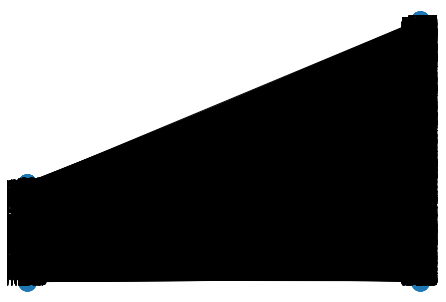

In [258]:
movie_set, actor_set = nx.bipartite.sets(graph)
pos = {}

pos.update((node, (1, index)) for index, node in enumerate(movie_set))
pos.update((node, (2, index)) for index, node in enumerate(actor_set))
nx.draw(graph, pos=pos, with_labels=True)
# it's very hard to see, but we can see this is very dense graph
plt.show()

In [259]:
movies=[]
actors=[]

for node in graph.nodes:
    if 'm' in node:
        movies.append(node)
    else:
        actors.append(node)
        
print("Total Number Unique of Movies", len(movies))

print("Total Number of Unique Actors", len(actors))

Total Number Unique of Movies 1292
Total Number of Unique Actors 3411


# Generate Node Embedding using [Representation Learning](https://stellargraph.readthedocs.io/en/stable/demos/embeddings/metapath2vec-embeddings.html?highlight=UniformRandomMetaPathWalk)
* We will use  random walks to get embeddings for all the movies and actors, we will user [metapath2Vec](https://ericdongyx.github.io/papers/KDD17-dong-chawla-swami-metapath2vec.pdf) algorithm
## Metapath2Vec algorithm
The Metapath2Vec algorithm introduced in  [metapath2Vec](https://ericdongyx.github.io/papers/KDD17-dong-chawla-swami-metapath2vec.pdf)  is a 2-step representation learning algorithm. The two steps are:

1. Use **uniform random walks**  to generate **sentences from a graph**. A sentence is a list of node IDs. The **set** of all sentences makes a **corpus**. The **random walk** is driven by a metapath that defines the **node type order by which the random walker explores the graph**.

2. The corpus is then used to learn an embedding vector for each node in the graph. Each node ID is considered a unique word/token in a dictionary that has size equal to the number of nodes in the graph. The **Word2Vec** algorithm is used for **calculating the embedding vectors.**
* Two possible Random Walk Model 
    1. [ Movie, Actor, Movie ]
    2. [ Actor, Movie, Actor ]
* We will do **100 random walks** and use randomwalks to **generate embedding using genism** 


In [260]:
# Create the random walker
rw = UniformRandomMetaPathWalk(StellarGraph(graph))

# specify the metapath schemas as a list of lists of node types.
metapaths = [
    ["movie", "actor", "movie"],
    ["actor", "movie", "actor"]
]

walks = rw.run(nodes=list(graph.nodes()), # root nodes
               length=100,  # maximum length of a random walk
               n=1,        # number of random walks per root node 
               metapaths=metapaths
              )

print("Number of random walks: {}".format(len(walks)))

Number of random walks: 4703


In [261]:
from gensim.models import Word2Vec
# walks is random walks sequence
# vector_size= embedding length
# window : window size to use in W2V model
model = Word2Vec(walks, vector_size=128, window=5)
print("Shape ",model.wv.vectors.shape)

Shape  (4703, 128)


In [262]:
node_ids = model.wv.index_to_key # list of node IDs
node_embeddings = model.wv.vectors  # numpy.ndarray of size number of nodes times embeddings dimensionality
node_targets = [ graph.nodes[node_id]['label'] for node_id in node_ids]


# Visualize Node Embeddings

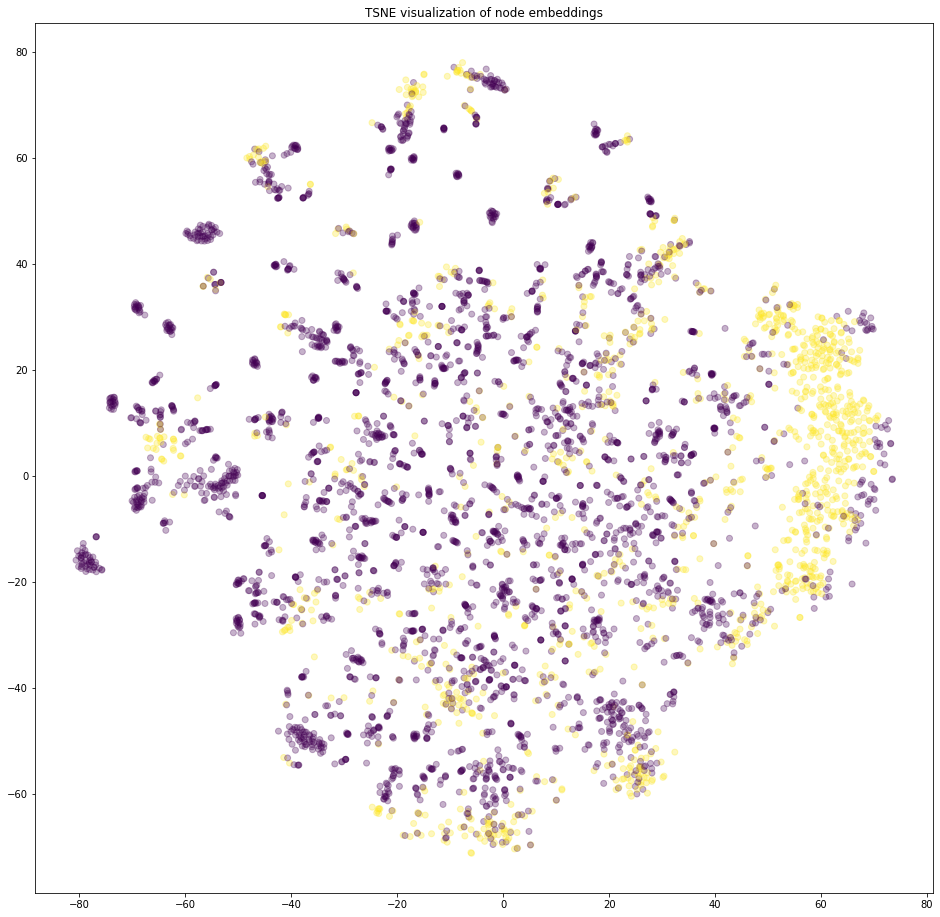

In [263]:

transform = TSNE #PCA

trans = transform(n_components=2)
node_embeddings_2d = trans.fit_transform(node_embeddings)
label_map = { l: i for i, l in enumerate(np.unique(node_targets))}
node_colours = [ label_map[target] for target in node_targets]

plt.figure(figsize=(20,16))
plt.axes().set(aspect="equal")
plt.scatter(node_embeddings_2d[:,0], 
            node_embeddings_2d[:,1], 
            c=node_colours, alpha=0.3)
plt.title('{} visualization of node embeddings'.format(transform.__name__))

plt.show()





## Observation

* TSNE plot we can see that there are some small small dense cluster for both actos and movies
* we need to apply sophisticated clustering algorithms to group similar actors and movies


# Applying clustering algorithm to group similar actors

 ### Flow of Algorithm
 
 1. Get all the actor nodes, and get actor embeddings
 2. Apply  clustering algorithm like AgglomerativeClustering, and Kmeans 
 3. Choose the number of clusters for which  maximum score of <b>$Cost1*Cost2$</b><br>
 4. Cost1 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(number of nodes in the largest connected component in the graph with the actor nodes and its movie neighbours in cluster i)}}{\text{(total number of nodes in that cluster i)}}$ where N= number of clusters 
<br>
 5. Cost2 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(sum of degress of actor nodes in the graph with the actor nodes and its movie neighbours in cluster i)}}{\text{(number of unique movie nodes in the graph with the actor nodes and its movie neighbours in cluster i)}}$ where N= number of clusters 
 <br> 
 6. Fit the clustering algorithm with the opimal number_of_clusters and get the cluster number for each node <br>
 7. Convert the d-dimensional dense vectors of nodes into 2-dimensional using dimensionality reduction techniques ( TSNE)<br>
 8. Plot the 2d scatter plot, with the node vectors after step 7  and give colors to nodes such that same cluster nodes will have same color

<pre>
	for number_of_clusters in [3, 5, 10, 30, 50, 100, 200, 500]:
		algo = clustering_algorith(clusters=number_of_clusters)
        
        # you will be passing a matrix of size N*d 
        # where N number of actor nodes and d is dimension from gensim
		
        algo.fit(the dense vectors of actor nodes) 
        
        #You can get the labels for corresponding actor nodes (algo.labels_)
        #Create a graph for every cluster(ie., if n_clusters=3, create 3 graphs)
        (You can use ego_graph to create subgraph from the actual graph)
        compute cost1,cost2 
           (if n_cluster=3, cost1=cost1(graph1)+cost1(graph2)+cost1(graph3) # here we are doing summation
            cost2=cost2(graph1)+cost2(graph2)+cost2(graph3)
		computer the metric Cost = Cost1*Cost2
	return number_of_clusters which have maximum Cost
	</pre>

In [264]:
print(node_targets[100:110])
print(node_ids[100:110])
print(node_embeddings[0].shape)

['actor', 'actor', 'movie', 'actor', 'movie', 'actor', 'actor', 'movie', 'movie', 'actor']
['a1436', 'a893', 'm1253', 'a228', 'm115', 'a1005', 'a1750', 'm796', 'm125', 'a1505']
(128,)


In [265]:
def data_split(node_ids,node_targets,node_embeddings):
    '''In this function, we will split the node embeddings into actor_embeddings , movie_embeddings '''
    actor_nodes,movie_nodes=[],[]
    actor_embeddings,movie_embeddings=[],[]
    # get actor_id index
    actor_ids = [idx for idx,node_id in enumerate(node_ids) if 'a' in node_id]
    # get movie_id index
    movie_ids = [idx for idx,node_id in enumerate(node_ids) if 'm' in node_id]
    
    # get all actor nodes using actor_ids
    actor_nodes = [node_ids[idx] for idx in actor_ids]
    # get all movie nodes using movie_ids
    movie_nodes = [node_ids[idx] for idx in movie_ids]
    
    # get actors embedding using actor_ids
    actor_embeddings = node_embeddings[actor_ids,:]
    # get movies embedding using movie_ids
    movie_embeddings = node_embeddings[movie_ids,:]
    return actor_nodes,movie_nodes,actor_embeddings,movie_embeddings

actor_nodes,movie_nodes,actor_embeddings,movie_embeddings = data_split(node_ids, node_targets, node_embeddings)

In [266]:
def grader_actors(data):
    assert(len(data)==3411)
    return True
grader_actors(actor_nodes)

True

In [267]:
def grader_movies(data):
    assert(len(data)==1292)
    return True
grader_movies(movie_nodes)

True

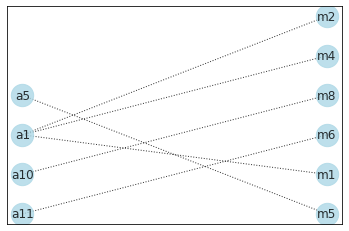

In [268]:
import networkx as nx
from networkx.algorithms import bipartite
graded_graph= nx.Graph()
graded_graph.add_nodes_from(['a1','a5','a10','a11'], bipartite=0) # Add the node attribute "bipartite"
graded_graph.add_nodes_from(['m1','m2','m4','m6','m5','m8'], bipartite=1)
graded_graph.add_edges_from([('a1','m1'),('a1','m2'),('a1','m4'),('a11','m6'),('a5','m5'),('a10','m8')])
l={'a1','a5','a10','a11'};r={'m1','m2','m4','m6','m5','m8'}
pos = {}
pos.update((node, (1, index)) for index, node in enumerate(l))
pos.update((node, (2, index)) for index, node in enumerate(r))
nx.draw_networkx(graded_graph, pos=pos, with_labels=True,node_color='lightblue',alpha=0.8,style='dotted',node_size=500)

In [269]:
def cost1(graph,number_of_clusters):
    '''In this function, we will calculate cost1'''
    # get all the connected components of graph
    Gcc = sorted(nx.connected_components(graph), key=len, reverse=True)
    # get largest connected component
    G0 = graph.subgraph(Gcc[0])
    # cost of connected components
    cost_G0 = len(G0.nodes)/len(graph.nodes)
    return cost_G0/number_of_clusters
    


In [270]:
graded_cost1=cost1(graded_graph,3)
# print(graded_cost1)
def grader_cost1(data):
    assert(data==((1/3)*(4/10))) # 1/3 is number of clusters
    return True
grader_cost1(graded_cost1)

True

In [271]:

# from functools import filter
def cost2(graph,number_of_clusters):
    '''In this function, we will calculate cost1'''
    sum_out_degree_actors= len(graph.edges)
    unique_movies_count = len(list(filter(lambda x: 'm' in x, graph.nodes)))
    cost2 = sum_out_degree_actors/unique_movies_count
    cost2 /= number_of_clusters
    return cost2


graded_cost2=cost2(graded_graph,3)
def grader_cost2(data):
    assert(data==((1/3)*(6/6))) # 1/3 is number of clusters
    return True
grader_cost2(graded_cost2)

True

In [272]:
def create_subgraph_from_cluster(graph, cluster,nodes):
    SG = graph.__class__()
    filter_nodes= np.array(nodes)[cluster]
    SG.add_nodes_from(filter_nodes)
    SG.add_edges_from((n, nbr, d)
            for n, nbrs in graph.adj.items() if n in filter_nodes
            for nbr, d in nbrs.items())
    SG.graph.update(graph.graph)
    return SG

In [273]:
def getBestCluster(graph,embeddings, nodes):
    cluster_choice = [3, 5,7, 10, 15,20,25, 30, 50, 100, 200, 500]
    algorithms = ['KMeans','AgglomerativeClustering']
    result={}
    for algo in algorithms:
        for k in cluster_choice:
            if algo == 'KMeans':
                Algo = KMeans
                clustering = KMeans(n_clusters=k, random_state=1000).fit(embeddings)
            elif algo == 'AgglomerativeClustering':
                Algo = AgglomerativeClustering
                clustering = AgglomerativeClustering(n_clusters=k).fit(embeddings)
            labels = clustering.labels_
            cluster_cost1=[]
            cluster_cost2=[]
            # get node ids for each cluster
            cluster_labels = [np.where(labels==label)[0] for label in np.unique(labels) ]

            # for each cluster form a subgraph calculate the cost and add all cost 
            for num,cluster in enumerate(cluster_labels):
                SG = create_subgraph_from_cluster(graph, cluster,nodes)
                c1=cost1(SG,k )
                c2=cost2(SG,k )
                cluster_cost1.append(c1)
                cluster_cost2.append(c2)
            print("{} : cluster number {}, cost1 {:.4f}, cost2 {:.4f} total cost {:.4f}".
                  format(Algo.__name__, k, np.sum(cluster_cost1),np.sum(cluster_cost2), np.sum(cluster_cost1) * np.sum(cluster_cost2)))
            result[(algo,k)] = np.sum(cluster_cost1) * np.sum(cluster_cost2)

    

    result_sort = {k: v for k, v in sorted(result.items(), key=lambda item: item[1], reverse=True)}
    return result_sort

    

In [274]:
# cluster_choice = [3, 5,7, 10, 15,20,25, 30, 50, 100, 200, 500]
# cost1_list=[]
# cost2_list=[]
# result={}
# for k in cluster_choice:
    
#     clustering = KMeans(n_clusters=k, random_state=1000).fit(actor_embeddings)
#     labels = clustering.labels_
#     cluster_cost1=[]
#     cluster_cost2=[]
#     total_cost = []
#     # get node ids for each cluster
#     cluster_labels = [np.where(labels==label)[0] for label in np.unique(labels) ]

#     # for each cluster form a subgraph calculate the cost and add all cost 
# #     print(len(cluster_labels))
#     for num,cluster in enumerate(cluster_labels):
# #         print(cluster)
#         SG = create_subgraph_from_cluster(graph, cluster,actor_nodes)
# #         print("node",len(SG.nodes))
#         c1=cost1(SG,k )
#         c2=cost2(SG,k )
#         cluster_cost1.append(c1)
#         cluster_cost2.append(c2)
#     print("k {}, cost1 {}, cost2 {} total cost {}".
#           format(k, np.sum(cluster_cost1),np.sum(cluster_cost2), np.sum(cluster_cost1) * np.sum(cluster_cost2)))
#     result[k] = np.sum(cluster_cost1) * np.sum(cluster_cost2)
    
        
    
# print(result)
    


In [282]:
result_sort = getBestCluster(graph, actor_embeddings, actor_nodes)
result_sort

KMeans : cluster number 3, cost1 0.9065, cost2 4.0867 total cost 3.7044
KMeans : cluster number 5, cost1 0.8813, cost2 3.2340 total cost 2.8501
KMeans : cluster number 7, cost1 0.9095, cost2 2.8410 total cost 2.5840
KMeans : cluster number 10, cost1 0.8904, cost2 2.5103 total cost 2.2352
KMeans : cluster number 15, cost1 0.8825, cost2 2.2655 total cost 1.9993
KMeans : cluster number 20, cost1 0.8050, cost2 2.1629 total cost 1.7412
KMeans : cluster number 25, cost1 0.8475, cost2 2.0319 total cost 1.7220
KMeans : cluster number 30, cost1 0.8377, cost2 1.9778 total cost 1.6567
KMeans : cluster number 50, cost1 0.8144, cost2 1.9434 total cost 1.5828
KMeans : cluster number 100, cost1 0.8643, cost2 1.7631 total cost 1.5238
KMeans : cluster number 200, cost1 0.8505, cost2 1.9700 total cost 1.6755
KMeans : cluster number 500, cost1 0.8922, cost2 2.1170 total cost 1.8888
AgglomerativeClustering : cluster number 3, cost1 0.9717, cost2 4.1373 total cost 4.0202
AgglomerativeClustering : cluster n

{('AgglomerativeClustering', 3): 4.02017711089385,
 ('KMeans', 3): 3.7044024616588422,
 ('KMeans', 5): 2.850069799601999,
 ('AgglomerativeClustering', 5): 2.8332828517303708,
 ('KMeans', 7): 2.584033338039275,
 ('AgglomerativeClustering', 7): 2.541122072092084,
 ('KMeans', 10): 2.2351846482928335,
 ('AgglomerativeClustering', 500): 2.1267587710433182,
 ('AgglomerativeClustering', 10): 2.1240265894314265,
 ('AgglomerativeClustering', 200): 2.1203304832269794,
 ('KMeans', 15): 1.9993159869245574,
 ('AgglomerativeClustering', 15): 1.913562732508371,
 ('AgglomerativeClustering', 20): 1.9039113355911446,
 ('KMeans', 500): 1.8888009405128423,
 ('AgglomerativeClustering', 30): 1.8821039567601765,
 ('AgglomerativeClustering', 25): 1.8691145712133723,
 ('AgglomerativeClustering', 100): 1.7412408079450554,
 ('KMeans', 20): 1.741204576354041,
 ('AgglomerativeClustering', 50): 1.7379526089933135,
 ('KMeans', 25): 1.7219946823677919,
 ('KMeans', 200): 1.6755461084217713,
 ('KMeans', 30): 1.65668918

In [285]:
actor_res_list=[]
for key,value in result_sort.items():
    actor_res_list.append([key[0],key[1], value])
actor_clustering_res_df = pd.DataFrame(np.array(actor_res_list),columns=['Clustering Method','no of cluster','cost'])
actor_clustering_res_df

,Clustering Method,no of cluster,cost
0,AgglomerativeClustering,3,4.02017711089385
1,KMeans,3,3.7044024616588422
2,KMeans,5,2.850069799601999
3,AgglomerativeClustering,5,2.8332828517303708
4,KMeans,7,2.584033338039275
5,AgglomerativeClustering,7,2.541122072092084
6,KMeans,10,2.2351846482928335
7,AgglomerativeClustering,500,2.1267587710433182
8,AgglomerativeClustering,10,2.1240265894314265
9,AgglomerativeClustering,200,2.1203304832269794


In [286]:
print("Best Clustering method {} with  Total Cost  with total number of cluster {}  and cost {}".format("AgglomerativeClustering", 3,4.02))

Best Clustering method AgglomerativeClustering with  Total Cost  with total number of cluster 3  and cost 4.02


## Get Optimum Cluster for similar actors and Visualize Embeddings

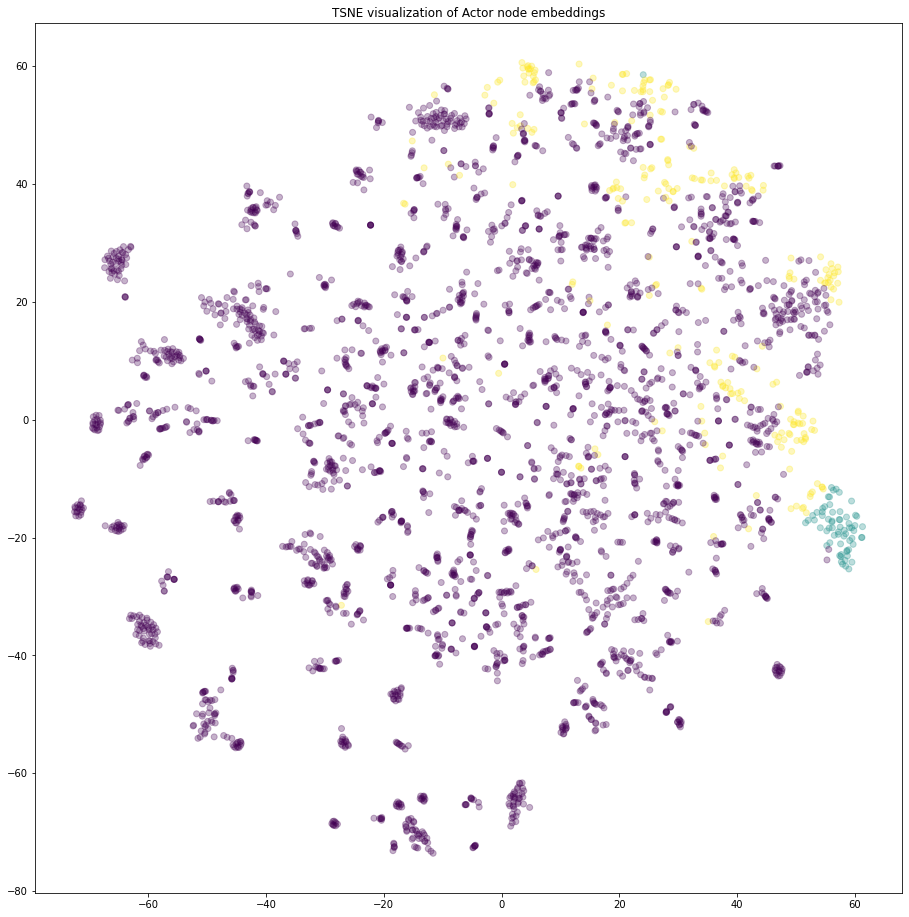

In [287]:
best_clustering = AgglomerativeClustering(n_clusters=3).fit(actor_embeddings)
best_labels = best_clustering.labels_

trans = TSNE(n_components=2)

node_embeddings_2d = trans.fit_transform(actor_embeddings)
 
# label_map = { l: i for i, l in enumerate(np.unique(node_targets))}

plt.figure(figsize=(20,16))
plt.axes().set(aspect="equal")
plt.scatter(node_embeddings_2d[:,0], 
            node_embeddings_2d[:,1], 
            c=best_labels, alpha=0.3)
plt.title('{} visualization of Actor node embeddings'.format(transform.__name__))

plt.show()


# Applying Clustering Algorithm to group similar Movies

 1. Get all the movie nodes, and get movie embeddings
 2. Apply  clustering algorithm like AgglomerativeClustering, and Kmeans 
 3. Choose the number of clusters for which  maximum score of <b>$Cost1*Cost2$</b><br>
 4. Cost1 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(number of nodes in the largest connected component in the graph with the movie nodes and its actor neighbours in cluster i)}}{\text{(total number of nodes in that cluster i)}}$ where N= number of clusters <br>
 5. Cost2 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(sum of degress of movie nodes in the graph with the movie nodes and its actor neighbours in cluster i)}}{\text{(number of unique actor nodes in the graph with the movie nodes and its actor neighbours in cluster i)}}$ 
where N= number of clusters 
<br>
 6. Fit the clustering algorithm with the opimal number_of_clusters and get the cluster number for each node <br>
 7. Convert the d-dimensional dense vectors of nodes into 2-dimensional using dimensionality reduction techniques ( TSNE)<br>
 8. Plot the 2d scatter plot, with the node vectors after step 7  and give colors to nodes such that same cluster nodes will have same color

In [278]:
# cluster_choice = [3, 5,7, 10, 15,20,25, 30, 50, 100, 200, 500]
# cost1_list=[]
# cost2_list=[]
# result={}
# for k in cluster_choice:
#     clustering = KMeans(n_clusters=k, random_state=1000).fit(movie_embeddings)
#     labels = clustering.labels_
#     cluster_cost1=[]
#     cluster_cost2=[]
#     total_cost = []
#     # get node ids for each cluster
#     cluster_labels = [np.where(labels==label)[0] for label in np.unique(labels) ]

#     # for each cluster form a subgraph calculate the cost and add all cost 
# #     print(len(cluster_labels))
#     for num,cluster in enumerate(cluster_labels):
# #         print(cluster)
#         SG = create_subgraph_from_cluster(graph, cluster,movie_nodes)
# #         print("node",len(SG.nodes))
#         c1=cost1(SG,k )
#         c2=cost2(SG,k )
#         cluster_cost1.append(c1)
#         cluster_cost2.append(c2)
#     print("k {}, cost1 {:.2f}, cost2 {:.2f} total cost {:.2f}".
#           format(k, np.sum(cluster_cost1),np.sum(cluster_cost2), np.sum(cluster_cost1) * np.sum(cluster_cost2)))
#     result[k] = np.sum(cluster_cost1) * np.sum(cluster_cost2)
    
        
    
# print(result)
    


In [288]:
# sort the result based on descending order of cost value
movies_result_sort = getBestCluster(graph, movie_embeddings, movie_nodes)
movies_result_sort



KMeans : cluster number 3, cost1 0.9797, cost2 8.4525 total cost 8.2811
KMeans : cluster number 5, cost1 0.9682, cost2 8.9116 total cost 8.6285
KMeans : cluster number 7, cost1 0.9606, cost2 10.1208 total cost 9.7222
KMeans : cluster number 10, cost1 0.9274, cost2 9.5758 total cost 8.8801
KMeans : cluster number 15, cost1 0.9271, cost2 9.2278 total cost 8.5549
KMeans : cluster number 20, cost1 0.9278, cost2 11.8980 total cost 11.0390
KMeans : cluster number 25, cost1 0.9485, cost2 13.3603 total cost 12.6728
KMeans : cluster number 30, cost1 0.9566, cost2 12.8388 total cost 12.2818
KMeans : cluster number 50, cost1 0.9422, cost2 14.3891 total cost 13.5579
KMeans : cluster number 100, cost1 0.9686, cost2 14.4027 total cost 13.9500
KMeans : cluster number 200, cost1 0.9801, cost2 12.7753 total cost 12.5210
KMeans : cluster number 500, cost1 0.9966, cost2 10.4486 total cost 10.4129
AgglomerativeClustering : cluster number 3, cost1 0.9871, cost2 7.8219 total cost 7.7211
AgglomerativeCluster

{('KMeans', 100): 13.949965695814786,
 ('AgglomerativeClustering', 100): 13.657196380647648,
 ('KMeans', 50): 13.557877129138086,
 ('AgglomerativeClustering', 50): 13.081181298314261,
 ('KMeans', 25): 12.6728091198753,
 ('AgglomerativeClustering', 30): 12.63899292320005,
 ('KMeans', 200): 12.521011316521536,
 ('AgglomerativeClustering', 200): 12.424679026621922,
 ('KMeans', 30): 12.281782305090463,
 ('KMeans', 20): 11.038971534372982,
 ('KMeans', 500): 10.412859350977223,
 ('AgglomerativeClustering', 25): 10.347902276629783,
 ('AgglomerativeClustering', 500): 10.30022281333809,
 ('AgglomerativeClustering', 7): 10.143629651361113,
 ('KMeans', 7): 9.722159451120813,
 ('AgglomerativeClustering', 20): 9.144838554256808,
 ('AgglomerativeClustering', 10): 8.986229040961028,
 ('AgglomerativeClustering', 15): 8.963729349259578,
 ('KMeans', 10): 8.88012323958383,
 ('AgglomerativeClustering', 5): 8.805699187358545,
 ('KMeans', 5): 8.628513144119193,
 ('KMeans', 15): 8.554933703631285,
 ('KMeans'

In [290]:
movies_res_list=[]
for key,value in movies_result_sort.items():
    movies_res_list.append([key[0],key[1], value])
movies_clustering_res_df = pd.DataFrame(np.array(movies_res_list),columns=['Clustering Method','no of cluster','cost'])
movies_clustering_res_df

,Clustering Method,no of cluster,cost
0,KMeans,100,13.949965695814786
1,AgglomerativeClustering,100,13.657196380647648
2,KMeans,50,13.557877129138086
3,AgglomerativeClustering,50,13.081181298314261
4,KMeans,25,12.6728091198753
5,AgglomerativeClustering,30,12.63899292320005
6,KMeans,200,12.521011316521536
7,AgglomerativeClustering,200,12.424679026621922
8,KMeans,30,12.281782305090463
9,KMeans,20,11.038971534372982


In [292]:
print("Best Clustering method {} with  Total Cost  with total number of cluster {}  and cost {}".format("KMeans", 100,13.9499))

Best Clustering method KMeans with  Total Cost  with total number of cluster 100  and cost 13.9499


## Get Optimum Cluster for similar movies and Visualize Embeddings

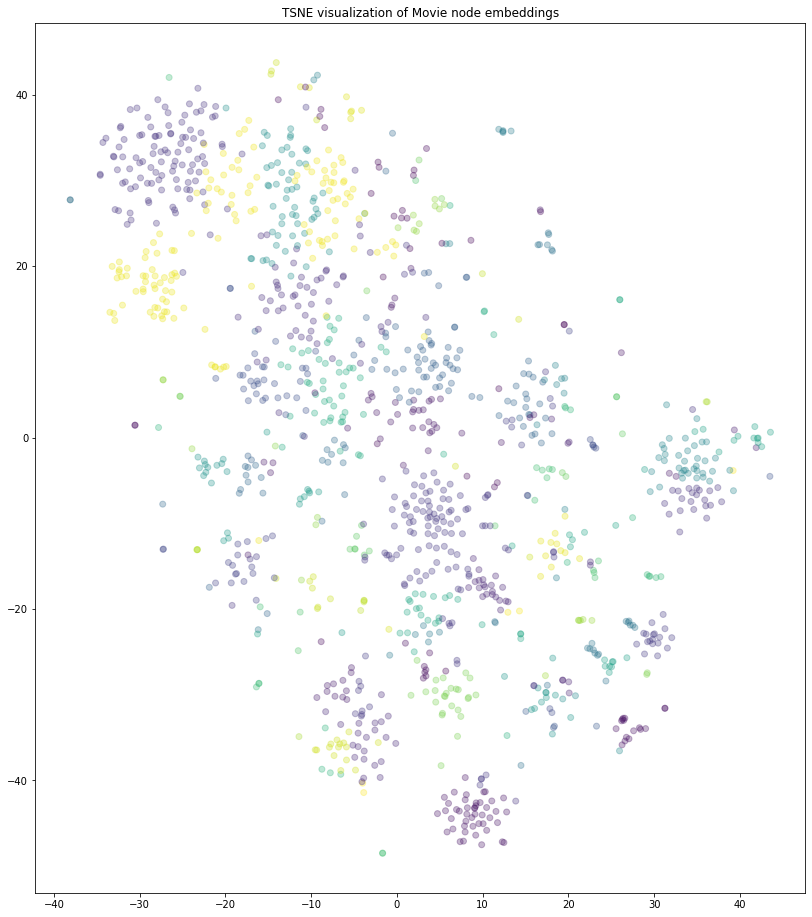

In [293]:
best_clustering = KMeans(n_clusters=100, random_state=110).fit(movie_embeddings)
best_labels = best_clustering.labels_

trans = TSNE(n_components=2)

node_embeddings_2d = trans.fit_transform(movie_embeddings)
 
# label_map = { l: i for i, l in enumerate(np.unique(node_targets))}

plt.figure(figsize=(20,16))
plt.axes().set(aspect="equal")
plt.scatter(node_embeddings_2d[:,0], 
            node_embeddings_2d[:,1], 
            c=best_labels, alpha=0.3)
plt.title('{} visualization of Movie node embeddings'.format(transform.__name__))

plt.show()
